Guild:
-simple is best
-fill the NA with missing.
-log the saleprice.



Include Library

In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import cross_val_score, train_test_split
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.linear_model import LinearRegression, RidgeCV, LassoCV, ElasticNetCV
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_squared_error, make_scorer
from scipy.stats import skew
from IPython.display import display
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split , StratifiedKFold

from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.model_selection import KFold

from sklearn.linear_model import Ridge, RidgeCV, ElasticNet, LassoCV, LassoLarsCV
from sklearn.model_selection import cross_val_score

# Definitions
pd.set_option('display.float_format', lambda x: '%.3f' % x)
%matplotlib inline
#njobs = 4

#print the results not only the last line of code.
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

import warnings
warnings.filterwarnings(action="ignore", module="scipy", message="^internal gelsd")

Input Data

In [2]:
train = pd.read_csv("input/train.csv")
print("train : " + str(train.shape))
test = pd.read_csv("input/test.csv")
print("test : " + str(test.shape))


all_data = pd.concat( [ train, test] , axis=0 )
print("all_data : " + str(all_data.shape))
trainAA=all_data[:train.shape[0]]
testAA=all_data[train.shape[0]:]
trainAA.shape
testAA.shape

train : (1460, 81)
test : (1459, 80)
all_data : (2919, 81)


(1460, 81)

(1459, 81)

In [3]:
# Check for duplicates
idsUnique = len(set(all_data.Id))
idsTotal = all_data.shape[0]
idsDupli = idsTotal - idsUnique
print("There are " + str(idsDupli) + " duplicate IDs for " + str(idsTotal) + " total entries")


# Drop Id column
all_data.drop("Id", axis = 1, inplace = True)



There are 0 duplicate IDs for 2919 total entries


Delete Outliers

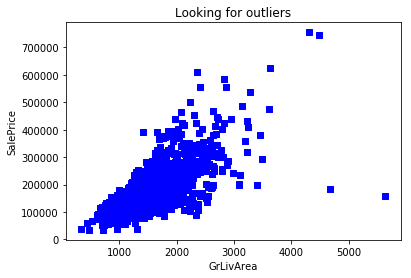

(2914, 80)

In [4]:
# Looking for outliers, as indicated in https://ww2.amstat.org/publications/jse/v19n3/decock.pdf
plt.scatter(all_data.GrLivArea, all_data.SalePrice, c = "blue", marker = "s")
plt.title("Looking for outliers")
plt.xlabel("GrLivArea")
plt.ylabel("SalePrice")
plt.show()

all_data = all_data[all_data.GrLivArea < 4000]
all_data.shape
plt.show()

trainshape=train.shape[0]-5



Transform price.
Taking logs means that errors in predicting expensive houses and cheap houses will affect the result equally.

In [5]:
# Log transform the target for official scoring
all_data.SalePrice = np.log1p(all_data.SalePrice)

y = all_data.SalePrice

Fill Data

In [6]:
# Handle missing values for features where median/mean or most common value doesn't make sense

# Alley : data description says NA means "no alley access"
all_data.loc[:, "Alley"] = all_data.loc[:, "Alley"].fillna("None")
# BedroomAbvGr : NA most likely means 0
all_data.loc[:, "BedroomAbvGr"] = all_data.loc[:, "BedroomAbvGr"].fillna(0)
# BsmtQual etc : data description says NA for basement features is "no basement"
all_data.loc[:, "BsmtQual"] = all_data.loc[:, "BsmtQual"].fillna("No")
all_data.loc[:, "BsmtCond"] = all_data.loc[:, "BsmtCond"].fillna("No")
all_data.loc[:, "BsmtExposure"] = all_data.loc[:, "BsmtExposure"].fillna("No")
all_data.loc[:, "BsmtFinType1"] = all_data.loc[:, "BsmtFinType1"].fillna("No")
all_data.loc[:, "BsmtFinType2"] = all_data.loc[:, "BsmtFinType2"].fillna("No")
all_data.loc[:, "BsmtFullBath"] = all_data.loc[:, "BsmtFullBath"].fillna(0)
all_data.loc[:, "BsmtHalfBath"] = all_data.loc[:, "BsmtHalfBath"].fillna(0)
all_data.loc[:, "BsmtUnfSF"] = all_data.loc[:, "BsmtUnfSF"].fillna(0)
# CentralAir : NA most likely means No
all_data.loc[:, "CentralAir"] = all_data.loc[:, "CentralAir"].fillna("N")
# Condition : NA most likely means Normal
all_data.loc[:, "Condition1"] = all_data.loc[:, "Condition1"].fillna("Norm")
all_data.loc[:, "Condition2"] = all_data.loc[:, "Condition2"].fillna("Norm")
# EnclosedPorch : NA most likely means no enclosed porch
all_data.loc[:, "EnclosedPorch"] = all_data.loc[:, "EnclosedPorch"].fillna(0)
# External stuff : NA most likely means average
all_data.loc[:, "ExterCond"] = all_data.loc[:, "ExterCond"].fillna("TA")
all_data.loc[:, "ExterQual"] = all_data.loc[:, "ExterQual"].fillna("TA")
# Fence : data description says NA means "no fence"
all_data.loc[:, "Fence"] = all_data.loc[:, "Fence"].fillna("No")
# FireplaceQu : data description says NA means "no fireplace"
all_data.loc[:, "FireplaceQu"] = all_data.loc[:, "FireplaceQu"].fillna("No")
all_data.loc[:, "Fireplaces"] = all_data.loc[:, "Fireplaces"].fillna(0)
# Functional : data description says NA means typical
all_data.loc[:, "Functional"] = all_data.loc[:, "Functional"].fillna("Typ")
# GarageType etc : data description says NA for garage features is "no garage"
all_data.loc[:, "GarageType"] = all_data.loc[:, "GarageType"].fillna("No")
all_data.loc[:, "GarageFinish"] = all_data.loc[:, "GarageFinish"].fillna("No")
all_data.loc[:, "GarageQual"] = all_data.loc[:, "GarageQual"].fillna("No")
all_data.loc[:, "GarageCond"] = all_data.loc[:, "GarageCond"].fillna("No")
all_data.loc[:, "GarageArea"] = all_data.loc[:, "GarageArea"].fillna(0)
all_data.loc[:, "GarageCars"] = all_data.loc[:, "GarageCars"].fillna(0)
# HalfBath : NA most likely means no half baths above grade
all_data.loc[:, "HalfBath"] = all_data.loc[:, "HalfBath"].fillna(0)
# HeatingQC : NA most likely means typical
all_data.loc[:, "HeatingQC"] = all_data.loc[:, "HeatingQC"].fillna("TA")
# KitchenAbvGr : NA most likely means 0
all_data.loc[:, "KitchenAbvGr"] = all_data.loc[:, "KitchenAbvGr"].fillna(0)
# KitchenQual : NA most likely means typical
all_data.loc[:, "KitchenQual"] = all_data.loc[:, "KitchenQual"].fillna("TA")
# LotFrontage : NA most likely means no lot frontage
all_data.loc[:, "LotFrontage"] = all_data.loc[:, "LotFrontage"].fillna(0)
# LotShape : NA most likely means regular
all_data.loc[:, "LotShape"] = all_data.loc[:, "LotShape"].fillna("Reg")
# MasVnrType : NA most likely means no veneer
all_data.loc[:, "MasVnrType"] = all_data.loc[:, "MasVnrType"].fillna("None")
all_data.loc[:, "MasVnrArea"] = all_data.loc[:, "MasVnrArea"].fillna(0)
# MiscFeature : data description says NA means "no misc feature"
all_data.loc[:, "MiscFeature"] = all_data.loc[:, "MiscFeature"].fillna("No")
all_data.loc[:, "MiscVal"] = all_data.loc[:, "MiscVal"].fillna(0)
# OpenPorchSF : NA most likely means no open porch
all_data.loc[:, "OpenPorchSF"] = all_data.loc[:, "OpenPorchSF"].fillna(0)
# PavedDrive : NA most likely means not paved
all_data.loc[:, "PavedDrive"] = all_data.loc[:, "PavedDrive"].fillna("N")
# PoolQC : data description says NA means "no pool"
all_data.loc[:, "PoolQC"] = all_data.loc[:, "PoolQC"].fillna("No")
all_data.loc[:, "PoolArea"] = all_data.loc[:, "PoolArea"].fillna(0)
# SaleCondition : NA most likely means normal sale
all_data.loc[:, "SaleCondition"] = all_data.loc[:, "SaleCondition"].fillna("Normal")
# ScreenPorch : NA most likely means no screen porch
all_data.loc[:, "ScreenPorch"] = all_data.loc[:, "ScreenPorch"].fillna(0)
# TotRmsAbvGrd : NA most likely means 0
all_data.loc[:, "TotRmsAbvGrd"] = all_data.loc[:, "TotRmsAbvGrd"].fillna(0)
# Utilities : NA most likely means all public utilities
all_data.loc[:, "Utilities"] = all_data.loc[:, "Utilities"].fillna("AllPub")
# WoodDeckSF : NA most likely means no wood deck
all_data.loc[:, "WoodDeckSF"] = all_data.loc[:, "WoodDeckSF"].fillna(0)

In [7]:
# Some numerical features are actually really categories
all_data = all_data.replace({"MSSubClass" : {20 : "SC20", 30 : "SC30", 40 : "SC40", 45 : "SC45", 
                                       50 : "SC50", 60 : "SC60", 70 : "SC70", 75 : "SC75", 
                                       80 : "SC80", 85 : "SC85", 90 : "SC90", 120 : "SC120", 
                                       150 : "SC150", 160 : "SC160", 180 : "SC180", 190 : "SC190"},
                       "MoSold" : {1 : "Jan", 2 : "Feb", 3 : "Mar", 4 : "Apr", 5 : "May", 6 : "Jun",
                                   7 : "Jul", 8 : "Aug", 9 : "Sep", 10 : "Oct", 11 : "Nov", 12 : "Dec"}
                      })
mss = pd.DataFrame()
mss["MSSubClass"]= all_data.MSSubClass
mss.head()

,MSSubClass
0,SC60
1,SC20
2,SC60
3,SC70
4,SC60


Skip 1* Simplifications of existing features
     2* Combinations of existing features
     

In [8]:
# Get dummies

#all_data = pd.get_dummies(all_data)
#all_data.head()

In [9]:
# Find most important features relative to target
print("Find most important features relative to target")
corr = all_data.corr()
corr.sort_values(["SalePrice"], ascending = False, inplace = True)
print(corr.SalePrice)

Find most important features relative to target
SalePrice        1.000
OverallQual      0.819
GrLivArea        0.719
GarageCars       0.680
GarageArea       0.655
TotalBsmtSF      0.642
1stFlrSF         0.614
FullBath         0.591
YearBuilt        0.589
YearRemodAdd     0.569
GarageYrBlt      0.544
TotRmsAbvGrd     0.533
Fireplaces       0.487
MasVnrArea       0.426
BsmtFinSF1       0.383
WoodDeckSF       0.331
OpenPorchSF      0.327
HalfBath         0.311
2ndFlrSF         0.307
LotArea          0.259
BsmtFullBath     0.239
BsmtUnfSF        0.223
BedroomAbvGr     0.204
LotFrontage      0.174
ScreenPorch      0.124
3SsnPorch        0.056
PoolArea         0.041
BsmtFinSF2       0.006
BsmtHalfBath    -0.015
MiscVal         -0.020
YrSold          -0.034
OverallCond     -0.037
LowQualFinSF    -0.038
KitchenAbvGr    -0.148
EnclosedPorch   -0.149
Name: SalePrice, dtype: float64


In [10]:
# Create new features
# 3* Polynomials on the top 10 existing features
all_data["OverallQual-s2"] = all_data["OverallQual"] ** 2
all_data["OverallQual-s3"] = all_data["OverallQual"] ** 3
all_data["OverallQual-Sq"] = np.sqrt(all_data["OverallQual"])
all_data["TotalBsmtSF-2"] = all_data["TotalBsmtSF"] ** 2
all_data["TotalBsmtSF-3"] = all_data["TotalBsmtSF"] ** 3
all_data["TotalBsmtSF-Sq"] = np.sqrt(all_data["TotalBsmtSF"])
all_data["1stFlrSF-2"] = all_data["1stFlrSF"] ** 2
all_data["1stFlrSF-3"] = all_data["1stFlrSF"] ** 3
all_data["1stFlrSF-Sq"] = np.sqrt(all_data["1stFlrSF"])
all_data["GrLivArea-2"] = all_data["GrLivArea"] ** 2
all_data["GrLivArea-3"] = all_data["GrLivArea"] ** 3
all_data["GrLivArea-Sq"] = np.sqrt(all_data["GrLivArea"])
all_data["YearBuilt-s2"] = all_data["YearBuilt"] ** 2
all_data["YearBuilt-s3"] = all_data["YearBuilt"] ** 3
all_data["YearBuilt-Sq"] = np.sqrt(all_data["YearBuilt"])
all_data["YearRemodAdd-2"] = all_data["YearRemodAdd"] ** 2
all_data["YearRemodAdd-3"] = all_data["YearRemodAdd"] ** 3
all_data["YearRemodAdd-Sq"] = np.sqrt(all_data["YearRemodAdd"])
all_data["GarageCars-2"] = all_data["GarageCars"] ** 2
all_data["GarageCars-3"] = all_data["GarageCars"] ** 3
all_data["GarageCars-Sq"] = np.sqrt(all_data["GarageCars"])
all_data["FullBath-2"] = all_data["FullBath"] ** 2
all_data["FullBath-3"] = all_data["FullBath"] ** 3
all_data["FullBath-Sq"] = np.sqrt(all_data["FullBath"])
all_data["GarageYrBlt-2"] = all_data["GarageYrBlt"] ** 2
all_data["GarageYrBlt-3"] = all_data["GarageYrBlt"] ** 3
all_data["GarageYrBlt-Sq"] = np.sqrt(all_data["GarageYrBlt"])
all_data["TotRmsAbvGrd-2"] = all_data["TotRmsAbvGrd"] ** 2
all_data["TotRmsAbvGrd-3"] = all_data["TotRmsAbvGrd"] ** 3
all_data["TotRmsAbvGrd-Sq"] = np.sqrt(all_data["TotRmsAbvGrd"])

In [11]:
# Differentiate numerical features (minus the target) and categorical features
categorical_features = all_data.select_dtypes(include = ["object"]).columns
numerical_features = all_data.select_dtypes(exclude = ["object"]).columns
numerical_features = numerical_features.drop("SalePrice")
print("Numerical features : " + str(len(numerical_features)))
print("Categorical features : " + str(len(categorical_features)))
all_data_num = all_data[numerical_features]
all_data_cat = all_data[categorical_features]

Numerical features : 64
Categorical features : 45


In [12]:
# Handle remaining missing values for numerical features by using median as replacement
print("NAs for numerical features in all_data : " + str(all_data_num.isnull().values.sum()))
all_data_num = all_data_num.fillna(all_data_num.median())
print("Remaining NAs for numerical features in all_data : " + str(all_data_num.isnull().values.sum()))

NAs for numerical features in all_data : 642
Remaining NAs for numerical features in all_data : 0


In [13]:
all_data.isnull().sum()

1stFlrSF             0
2ndFlrSF             0
3SsnPorch            0
Alley                0
BedroomAbvGr         0
BldgType             0
BsmtCond             0
BsmtExposure         0
BsmtFinSF1           1
BsmtFinSF2           1
BsmtFinType1         0
BsmtFinType2         0
BsmtFullBath         0
BsmtHalfBath         0
BsmtQual             0
BsmtUnfSF            0
CentralAir           0
Condition1           0
Condition2           0
Electrical           1
EnclosedPorch        0
ExterCond            0
ExterQual            0
Exterior1st          1
Exterior2nd          1
Fence                0
FireplaceQu          0
Fireplaces           0
Foundation           0
FullBath             0
                  ... 
OverallQual-s2       0
OverallQual-s3       0
OverallQual-Sq       0
TotalBsmtSF-2        1
TotalBsmtSF-3        1
TotalBsmtSF-Sq       1
1stFlrSF-2           0
1stFlrSF-3           0
1stFlrSF-Sq          0
GrLivArea-2          0
GrLivArea-3          0
GrLivArea-Sq         0
YearBuilt-s

In [14]:

skewness = all_data_num.apply(lambda x: skew(x))
skewness = skewness[abs(skewness) > 0.5]
print(str(skewness.shape[0]) + " skewed numerical features to log transform")
skewed_features = skewness.index
all_data_num[skewed_features] = np.log1p(all_data_num[skewed_features])

44 skewed numerical features to log transform


Modeling

In [15]:
# Join categorical and numerical features
all_data = pd.concat([all_data_num, all_data_cat], axis = 1)

In [16]:
# Get dummies

all_data_D = pd.get_dummies(all_data)
all_data_D.head()

,1stFlrSF,2ndFlrSF,3SsnPorch,BedroomAbvGr,BsmtFinSF1,BsmtFinSF2,BsmtFullBath,BsmtHalfBath,BsmtUnfSF,EnclosedPorch,...,SaleType_ConLD,SaleType_ConLI,SaleType_ConLw,SaleType_New,SaleType_Oth,SaleType_WD,Street_Grvl,Street_Pave,Utilities_AllPub,Utilities_NoSeWa
0,6.753,6.751,0.000,3,6.561,0.000,0.693,0.000,5.017,0.000,...,0,0,0,0,0,1,0,1,1,0
1,7.141,0.000,0.000,3,6.887,0.000,0.000,0.693,5.652,0.000,...,0,0,0,0,0,1,0,1,1,0
2,6.825,6.765,0.000,3,6.188,0.000,0.693,0.000,6.075,0.000,...,0,0,0,0,0,1,0,1,1,0
3,6.869,6.629,0.000,3,5.380,0.000,0.693,0.000,6.293,5.609,...,0,0,0,0,0,1,0,1,1,0
4,7.044,6.960,0.000,4,6.486,0.000,0.693,0.000,6.196,0.000,...,0,0,0,0,0,1,0,1,1,0


In [17]:
# Standardize numerical features
stdSc = StandardScaler()
all_data_STD = stdSc.fit_transform(all_data_D)

In [18]:
#add qual features

quadratic=PolynomialFeatures(degree=2)
qual_X=quadratic.fit_transform(all_data_STD)
print ("qual shape:",qual_X.shape)

qual shape: (2914, 63903)


In [19]:
# PCA
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
my_pca = PCA(n_components=200)
print(all_data_STD.shape)
#missing feature scaling and normalization
my_pca.fit(all_data_STD)

trans_X = my_pca.transform(all_data_STD)

#my_pca.fit(qual_X)
#trans_QX =  my_pca.transform(qual_X)


trans_X=pd.DataFrame(trans_X)
print(trans_X.shape)
#trans_QX=pd.DataFrame(trans_QX)
#trans_X.head()

(2914, 356)


PCA(copy=True, iterated_power='auto', n_components=200, random_state=None,
  svd_solver='auto', tol=0.0, whiten=False)

(2914, 200)


In [20]:

# Split train and test
train_valid_X=trans_X[:trainshape]
train_valid_X.shape
train_valid_Y=y[:trainshape]
train_valid_Y.shape
test_X =trans_X[trainshape:]
test_X.shape



print("New number of features : " + str(trans_X.shape[1]))
# Partition the dataset in all_data + validation sets
X_train, X_test, y_train, y_test = train_test_split(train_valid_X, train_valid_Y, test_size = 0.3, random_state = 1)
print("X_train : " + str(X_train.shape))
print("X_test : " + str(X_test.shape))
print("y_train : " + str(y_train.shape))
print("y_test : " + str(y_test.shape))

(1455, 200)

(1455,)

(1459, 200)

New number of features : 200
X_train : (1018, 200)
X_test : (437, 200)
y_train : (1018,)
y_test : (437,)


In [42]:
# Define error measure for official scoring : RMSE
scorer = make_scorer(mean_squared_error, greater_is_better = False)


def rmse_cv(model):
    rmse= (-cross_val_score(model, train_valid_X, train_valid_Y, scoring="neg_mean_squared_error", cv = 10))
    return(rmse)

def run(model):
    
    model.fit(X_train, y_train)
    y_train_pred = model.predict(X_train)
    y_test_pred = model.predict(X_test)
    print ("training error      :",mean_squared_error(y_train, y_train_pred))
    print ("validation error    :",mean_squared_error(y_test, y_test_pred))
    print("RMSE on training set :", rmse_cv(model).mean())
    
    model.fit(train_valid_X, train_valid_Y)
    return model.predict(test_X)


from sklearn.cross_validation import KFold

def run_kfold(clf):
    kf = KFold(trainshape, n_folds=10)
    outcomes_train = []
    outcomes_test = []
    fold = 0
    for train_index, test_index in kf:
        fold += 1
        X_train, X_test = train_valid_X.values[train_index], train_valid_X.values[test_index]
        y_train, y_test = train_valid_Y.values[train_index], train_valid_Y.values[test_index]
        clf.fit(X_train, y_train)
        
        prediction_train = clf.predict(X_train)
        acc_train= mean_squared_error(y_train, prediction_train)
        outcomes_train.append(acc_train)
        
        prediction_test = clf.predict(X_test)
        acc_test = mean_squared_error(y_test, prediction_test)
        outcomes_test.append(acc_test)
        
        print("Fold {0} MSE training error: {1}".format(fold, acc_train), 
              "Fold {0} MSE test     error: {1}".format(fold, acc_test),)
    mean_outcome_train = np.mean(outcomes_train)
    mean_outcome_test= np.mean(outcomes_test)
    print("Mean MSE training error: {0}".format(mean_outcome_train)) 
    print("Mean MSE testint error : {0}".format(mean_outcome_test)) 
    clf.fit(train_valid_X, train_valid_Y)
    return clf.predict(test_X)


In [43]:
# Linear Regression
lr = LinearRegression()
y_pred_lr=run(lr)
y_pred_lr[:10]

training error      : 0.00806546658932
validation error    : 0.119894843787
RMSE on training set : 0.164751358804


array([ 11.93106184,  11.70902512,  11.91045619,  12.076171  ,
        12.15374688,  12.22332262,  12.01618502,  12.02195981,
        11.99599142,  12.12752975])

In [44]:
run_kfold(lr)

Fold 1 MSE training error: 0.009436449769983053 Fold 1 MSE test     error: 0.16087825748738568
Fold 2 MSE training error: 0.009800297079011592 Fold 2 MSE test     error: 0.08848639368376646
Fold 3 MSE training error: 0.009559949915969205 Fold 3 MSE test     error: 0.024739856934308118
Fold 4 MSE training error: 0.009446486879440401 Fold 4 MSE test     error: 0.017407458961096352
Fold 5 MSE training error: 0.008759863711045441 Fold 5 MSE test     error: 0.15372296006273314
Fold 6 MSE training error: 0.009916916796609167 Fold 6 MSE test     error: 0.020264476419886737
Fold 7 MSE training error: 0.009526316413315744 Fold 7 MSE test     error: 1.0595915503826838
Fold 8 MSE training error: 0.0097976224517772 Fold 8 MSE test     error: 0.013538491016672807
Fold 9 MSE training error: 0.010095067907303997 Fold 9 MSE test     error: 0.0706707391293009
Fold 10 MSE training error: 0.009427276449261116 Fold 10 MSE test     error: 0.03821340396012481
Mean MSE training error: 0.009576624737371692
Me

array([ 11.93106184,  11.70902512,  11.91045619, ...,  11.9456509 ,
        11.68594695,  12.26304027])

In [45]:
# Ridge
ridge=Ridge(alpha=200)
y_pred_ridge=run(ridge)

training error      : 0.00857299066961
validation error    : 0.0185039799278
RMSE on training set : 0.0150921967438


In [46]:
run_kfold(ridge)

Fold 1 MSE training error: 0.009735037219418433 Fold 1 MSE test     error: 0.01715703386959254
Fold 2 MSE training error: 0.0100538467039818 Fold 2 MSE test     error: 0.01384510938606414
Fold 3 MSE training error: 0.009760787482018144 Fold 3 MSE test     error: 0.01619296707386939
Fold 4 MSE training error: 0.009597482300804113 Fold 4 MSE test     error: 0.01653810078891805
Fold 5 MSE training error: 0.00911614811916043 Fold 5 MSE test     error: 0.02124905498421457
Fold 6 MSE training error: 0.010079591397059237 Fold 6 MSE test     error: 0.011447800721421432
Fold 7 MSE training error: 0.009766936028664115 Fold 7 MSE test     error: 0.015446160100188075
Fold 8 MSE training error: 0.009943226451894433 Fold 8 MSE test     error: 0.012047452809345565
Fold 9 MSE training error: 0.010269340370216063 Fold 9 MSE test     error: 0.010405626934160124
Fold 10 MSE training error: 0.009581885698392904 Fold 10 MSE test     error: 0.016592660770500114
Mean MSE training error: 0.009790428177160967


array([ 11.92311334,  11.69733138,  11.93309878, ...,  11.95025105,
        11.69272798,  12.2737879 ])

In [47]:
#lasso
lasso = LassoCV(alphas = [1, 0.1, 0.001, 0.0005]).fit(train_valid_X, train_valid_Y)
y_pred_lasso=run(lasso)

training error      : 0.00852303111925
validation error    : 0.0193484868658
RMSE on training set : 0.0156089385689


In [48]:
run_kfold(lasso)

Fold 1 MSE training error: 0.009771708073437371 Fold 1 MSE test     error: 0.018526771642947682
Fold 2 MSE training error: 0.010112655639006578 Fold 2 MSE test     error: 0.012612819126074301
Fold 3 MSE training error: 0.009793964460587284 Fold 3 MSE test     error: 0.01850496905648305
Fold 4 MSE training error: 0.00964006881350563 Fold 4 MSE test     error: 0.016860496896898412
Fold 5 MSE training error: 0.009151252488581722 Fold 5 MSE test     error: 0.021687367259801457
Fold 6 MSE training error: 0.010116785334234442 Fold 6 MSE test     error: 0.011480105493989099
Fold 7 MSE training error: 0.009818419188866697 Fold 7 MSE test     error: 0.01473483516427329
Fold 8 MSE training error: 0.009990153707561735 Fold 8 MSE test     error: 0.01192584426860616
Fold 9 MSE training error: 0.010322496969093202 Fold 9 MSE test     error: 0.01129554888794739
Fold 10 MSE training error: 0.009631103008006337 Fold 10 MSE test     error: 0.01846062789187089
Mean MSE training error: 0.00983486076828809

array([ 11.92715868,  11.69207351,  11.88108492, ...,  11.94479027,
        11.69986393,  12.27893051])

In [49]:
# Decision Tree
# Linear Regression
tree = DecisionTreeRegressor(max_depth=3)
Y_pred_tree=run(tree)

training error      : 0.0314377752959
validation error    : 0.0393432282486
RMSE on training set : 0.038947743347


In [50]:
run_kfold(tree)

Fold 1 MSE training error: 0.03328777597781518 Fold 1 MSE test     error: 0.03968724993486836
Fold 2 MSE training error: 0.032636641266061375 Fold 2 MSE test     error: 0.04086056013443112
Fold 3 MSE training error: 0.0333321108078447 Fold 3 MSE test     error: 0.03507857080606983
Fold 4 MSE training error: 0.03267855926480757 Fold 4 MSE test     error: 0.04272766028595117
Fold 5 MSE training error: 0.03179057702812759 Fold 5 MSE test     error: 0.045975061957582344
Fold 6 MSE training error: 0.03352075258291343 Fold 6 MSE test     error: 0.03471931569788638
Fold 7 MSE training error: 0.03352799644650096 Fold 7 MSE test     error: 0.032598953114340655
Fold 8 MSE training error: 0.03298962375994082 Fold 8 MSE test     error: 0.035420972435757085
Fold 9 MSE training error: 0.03280303975035968 Fold 9 MSE test     error: 0.0410528914540695
Fold 10 MSE training error: 0.03320439723683243 Fold 10 MSE test     error: 0.041356197649020904
Mean MSE training error: 0.03297714741212038
Mean MSE t

array([ 11.81414303,  11.58786235,  11.98000511, ...,  11.81414303,
        11.81414303,  12.26792073])

In [51]:
# Ridge
model_ridge = Ridge()
alphas = [0.05, 0.1, 0.3, 1, 3, 5, 10, 15, 30, 50, 75,100,150,200, 250,300,350,500,650,800,1250,2000]
cv_ridge = [rmse_cv(Ridge(alpha = alpha)).mean() 
            for alpha in alphas]

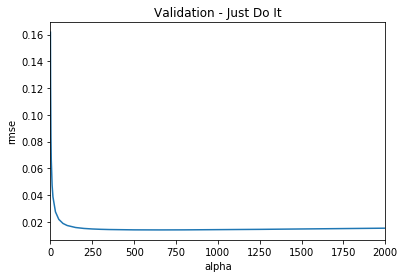

In [52]:
cv_ridge = pd.Series(cv_ridge, index = alphas)
cv_ridge.plot(title = "Validation - Just Do It")
plt.xlabel("alpha")
plt.ylabel("rmse")

In [ ]:
import xgboost as xgb

regr = xgb.XGBRegressor(
                 learning_rate=1,
                 min_child_weight=7,
                 gamma=1,
                 subsample=0.5,
                 colsample_bytree=0,
                 max_depth=100,
                 n_estimators=7200,                                                                  
                 reg_alpha=5,
                 reg_lambda=0,
                 
                 seed=1,
                 silent=1,
                 booster = 'gblinear')

regr
run(regr)

XGBRegressor(base_score=0.5, booster='gblinear', colsample_bylevel=1,
       colsample_bytree=0, gamma=1, learning_rate=1, max_delta_step=0,
       max_depth=100, min_child_weight=7, missing=None, n_estimators=7200,
       n_jobs=1, nthread=None, objective='reg:linear', random_state=0,
       reg_alpha=5, reg_lambda=0, scale_pos_weight=1, seed=1, silent=1,
       subsample=0.5)

training error      : 0.0108280850213
validation error    : 0.0184382541571


In [58]:
y_pred_regr=run_kfold(regr)

Fold 1 MSE training error: 0.0136187715233279 Fold 1 MSE test     error: 0.016051364553338655
Fold 2 MSE training error: 0.014150573387145236 Fold 2 MSE test     error: 0.013838909252194621
Fold 3 MSE training error: 0.013763007181741812 Fold 3 MSE test     error: 0.014240992990364808
Fold 4 MSE training error: 0.013603926832557123 Fold 4 MSE test     error: 0.01774994870027775
Fold 5 MSE training error: 0.013243728396974758 Fold 5 MSE test     error: 0.021063557844072135
Fold 6 MSE training error: 0.014063982563135471 Fold 6 MSE test     error: 0.012180486283955351
Fold 7 MSE training error: 0.013719230219229184 Fold 7 MSE test     error: 0.016796392363475784
Fold 8 MSE training error: 0.013871274522756561 Fold 8 MSE test     error: 0.012895218286593985
Fold 9 MSE training error: 0.01420317808876413 Fold 9 MSE test     error: 0.01251628030674713
Fold 10 MSE training error: 0.013521226062100636 Fold 10 MSE test     error: 0.017561962463971324
Mean MSE training error: 0.0137758898777732

In [ ]:
#grid_search
run_gs = True

if run_gs:
    parameters_grid = {
       'learning_rate' : [0.01,0.1,0.2,0.5,1],
        'min_child_weight':[1,3,5,7], 
       'gamma':[i/5.0 for i in range(0,5)], 
        'subsample':[i/5.0 for i in range(0,5)],
        'colsample_bytree':[i/5.0 for i in range(0,5)],
        'max_depth': [2,3,4,7,10,25],
        'reg_alpha':[0.01, 0.1, 1.0,10,100],
        'reg_lambda' : [0.0,0.001,0.01,0.1,1.0,10,100]
                     }

 
    regr = xgb.XGBRegressor(
                 learning_rate=0.5,
                 min_child_weight=4,
                 gamma=0.0,
                 subsample=0.1,
                 colsample_bytree=0.0,
                 max_depth=2,
                 #n_estimators=7200,                                                                  
                 reg_alpha=10,
                 reg_lambda=0.0,
                 
                 seed=42,
                 silent=1,
                 booster = 'gblinear')
    cross_validation = KFold(trainshape, n_folds=5)

    grid_search = GridSearchCV(regr,
                               param_grid=parameters_grid,
                               cv=cross_validation
                               )

    grid_search.fit(train_valid_X, train_valid_Y)
    model = grid_search
    parameters = grid_search.best_params_

    print('Best score: {}'.format(grid_search.best_score_))
    print('Best parameters: {}'.format(grid_search.best_params_))
else: 
    parameters = {'bootstrap': False, 'min_samples_leaf': 1, 'n_estimators': 50, 
                  'min_samples_split': 3, 'max_features': 'sqrt', 'max_depth': 8}
    
#    model = xbg.XGBRegressor(**parameters)

In [ ]:
# Plot residuals
plt.scatter(y_train_pred, y_train_pred - y_train, c = "blue", marker = "s", label = "Training data")
plt.scatter(y_test_pred, y_test_pred - y_test, c = "lightgreen", marker = "s", label = "Validation data")
plt.title("Linear regression")
plt.xlabel("Predicted values")
plt.ylabel("Residuals")
plt.legend(loc = "upper left")
plt.hlines(y = 0, xmin = 10.5, xmax = 13.5, color = "red")
plt.show()

# Plot predictions
plt.scatter(y_train_pred, y_train, c = "blue", marker = "s", label = "Training data")
plt.scatter(y_test_pred, y_test, c = "lightgreen", marker = "s", label = "Validation data")
plt.title("Linear regression")
plt.xlabel("Predicted values")
plt.ylabel("Real values")
plt.legend(loc = "upper left")
plt.plot([10.5, 13.5], [10.5, 13.5], c = "red")
plt.show()


In [ ]:
Id = test.Id
Id.shape
Y_predout_lr=np.expm1(y_pred_lr)
Y_predout_ridge=np.expm1(y_pred_ridge)
Y_predout_tree=np.expm1(y_pred_tree)
Y_predout_regr=np.expm1(y_pred_regr)
Y_predout_lasso=np.expm1(y_pred_lasso)
Y_predout=0.5*y_predout_lasso+0.5*y_predout_ridge
#+0.2*Y_predout_tree
#mean_squared_error(y_test, Y_predout)



#print (Y_predout==int)

Y_predout[:10]
#solution = pd.DataFrame({"id": Id, "SalePrice":Y_Pred})
#solution.to_csv("ridge_sol.csv", index = False)

In [ ]:
Y_predout_regr=np.expm1(y_pred_regr)

In [ ]:
solution = pd.DataFrame({"id": test.Id, "SalePrice":Y_predout_regr})
solution.to_csv("ridge_sol0808_XGB_3.csv", index = False)